```
Setting up and running Lorenz 96 model

Copyright (C) 2020  SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [67]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
import pandas as pd

#Helpful during development
import importlib
#importlib.reload(module)

import datetime
import time

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
init_X = np.random.normal(loc=0, scale=5, size=8)
init_Y = np.random.normal(loc=0, scale=1, size=(8,8))

In [44]:
class lorenz96:
    
    def __init__(self, nx=8, ny=8, nz=8, num_layers=3, 
                 end_T=5, store_Y=False, store_Z=False,
                 init_X=None, init_Y=None
                 ):
        
        self.nx, self.ny, self.nz = nx, ny, nz
        self.num_layers = num_layers
        
        if self.num_layers < 3:
            self.nz=1
        if self.num_layers < 2:
            self.ny=1
            
        if init_X is not None:
            assert(len(init_X) == self.nx), 'wrong size of init X'
        
        self.dt = 0.005
            
        self.end_T = end_T
        self.num_timesteps = int(self.end_T / 0.005)
        
        # Always store X
        self.X = np.zeros((self.num_timesteps+1, self.nx))
        
        # iteration counter
        self.it = 0
        self.t = 0.0
        
        # Initialzation:
        if init_X is not None:
            self.X[0,:] = init_X
        else:
            self.X[0,:] = np.random.normal(loc=0, scale=1, size=self.nx)
        
        if init_Y is not None:
            self.Y = init_Y
        else:
            self.Y = np.random.normal(loc=0, scale=1, size=(self.nx, self.ny))
        self.Z = np.random.normal(loc=0, scale=0.05, size=(self.nx,self.ny,self.nz))
        
        # Parameters (following those from Düben and Bauer, 2018)
        self.b, self.c, self.e, self.d = 10.0, 10.0, 10.0, 10.0
        self.h, self.g = 1.0, 1.0
        self.F = 20.0
        
        
        self.store_Y, self.store_Z = store_Y, store_Z
        if self.num_timesteps > 1000:
            if self.store_Y or self.store_Z:
                print('Ignoring store_Y and store_Z, since simulation will be too long')
            self.store_Y = False
            self.store_Z = False
        self.all_Y1, self.all_Z1 = None, None
        if self.store_Y:
            self.all_Y1 = np.zeros((self.num_timesteps+1, self.ny))
            self.all_Y1[0,:] = self.Y[0,:]
        if self.store_Z:
            self.all_Z1 = np.zeros((self.num_timesteps+1, self.nz))
            self.all_Z1[0,:] = self.Z[0, 0, :]
            
    def step(self, T, verbose=False, report_every=10000):
        """
        Step model forward until time T
        """
        
        T_in_iterations = int(T/self.dt)
        num_iterations = T_in_iterations - self.it
        
        tic = time.time()
        
        if self.it + num_iterations > self.num_timesteps:
            print('Asked for too many timesteps \n(allocated, already completed, asked for, would result in, will only do)\n', 
                  self.num_timesteps, self.it, num_iterations, self.it+num_iterations, self.num_timesteps - self.it)
            num_iterations = self.num_timesteps - self.it
        
        for i in range(num_iterations):
            self.X[self.it+1,:], self.Y, self.Z = self._rk4()
            
            if self.store_Y:
                self.all_Y1[self.it+1,:] = self.Y[0,:]
            if self.store_Z:
                self.all_Z1[self.it+1,:] = self.Z[0,0,:]
            
            self.it += 1
            
            if verbose and i > 0:
                if i%report_every == 0:
                    progress_in_percent = 100*i/num_iterations
                    toc = time.time()
                    print(str(int(progress_in_percent)).zfill(2)+' % after time (in s): ' + str(toc-tic))
    
    
    def _rk4(self):
        
        x1, y1, z1 = self._L96(self.X[self.it, :], self.Y, self.Z)
        
        x2, y2, z2 = self._L96(self.X[self.it, :] + x1*self.dt/2.0,
                               self.Y + y1*self.dt/2.0,
                               self.Z + z1*self.dt/2.0)
        
        x3, y3, z3 = self._L96(self.X[self.it, :] + x2*self.dt/2.0,
                               self.Y + y2*self.dt/2.0,
                               self.Z + z2*self.dt/2.0)
        
        x4, y4, z4 = self._L96(self.X[self.it, :] + x3*self.dt,
                               self.Y + y3*self.dt,
                               self.Z + z3*self.dt)
        
        new_x = self.X[self.it, :] + self.dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
        new_y = self.Y + self.dt*(y1 + 2*y2 + 2*y3 + y4)/6.0
        new_z = self.Z + self.dt*(z1 + 2*z2 + 2*z3 + z4)/6.0
        
        return new_x, new_y, new_z
        
        # RK4:
        #k1 = self._lorenz63_(p[:,k])
        #k2 = self._lorenz63_(p[:,k] + k1*self.dt/2.0)
        #k3 = self._lorenz63_(p[:,k] + k2*self.dt/2.0)
        #k4 = self._lorenz63_(p[:,k] + k3*self.dt)
        #p[:,k+1] = p[:,k] + self.dt*(k1 + 2*k2 + 2*k3 + k4)/6.0 + model_error

       
        
    def _L96(self, X, Y, Z):
        new_Y, new_Z = 0, 0
        
        new_X = np.roll(X,1)*(np.roll(X,-1) - np.roll(X,2)) - X + self.F
        if self.num_layers > 1:
            new_X -= (self.h*self.c/self.b)*Y.sum(axis=1)
            new_Y = -self.c*self.b*np.roll(Y,-1)*(np.roll(Y,-2) - np.roll(Y,1)) - self.c*Y + (self.h*self.c/self.b)*X[:, None] 
        if self.num_layers > 2:
            new_Y -= (self.h*self.e/self.d)*Z.sum(axis=2)
            new_Z = self.e*self.d*np.roll(Z,1)*(np.roll(Z,-1) - np.roll(Z,2)) - self.g*self.e*Z + (self.h*self.e/self.d)*Y[:,:,None]

        return new_X, new_Y, new_Z
        

class Ensemble:
    
    def __init__(self, Ne, physical_model=True, physical_model_params=None):
        
        self.Ne = Ne
        
        self.ensemble = [None]*self.Ne
        for i in range(self.Ne):
            self.ensemble[i] = lorenz96(**physical_model_params)
            
        self.mean = None
        
    def step(self, T):
        for member in self.ensemble:
            member.step(T)
    
    def update_mean(self):
        self.mean = np.zeros_like(self.ensemble[0].X)
        for member in self.ensemble:
            self.mean += member.X
        self.mean /= self.Ne
            

    
    

## Ensemble of 3-layer models with random init Z

In [4]:
lorenz_input = {
    'init_X': init_X,
    'init_Y': init_Y,
               }

In [5]:
physical_ensemble = Ensemble(50, physical_model_params=lorenz_input)
print(physical_ensemble.Ne)

50


In [6]:
%%time
physical_ensemble.step(5)

CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


In [7]:
physical_ensemble.update_mean()

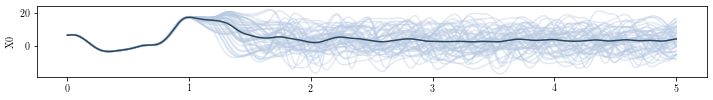

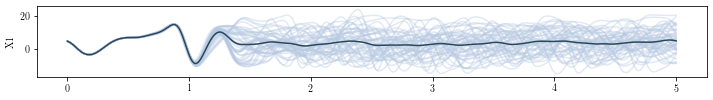

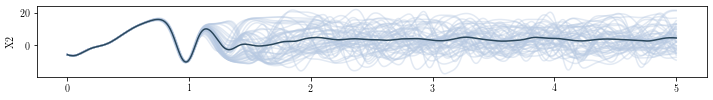

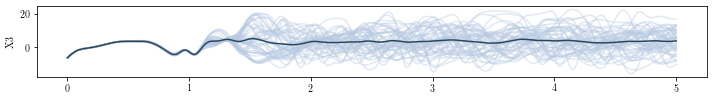

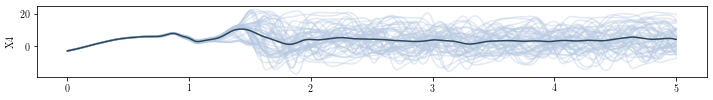

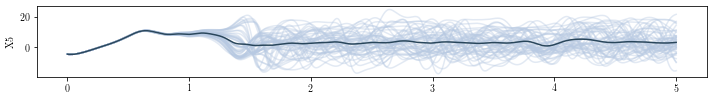

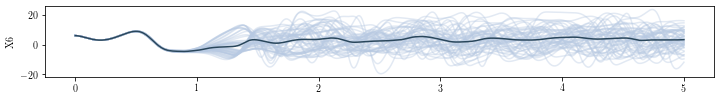

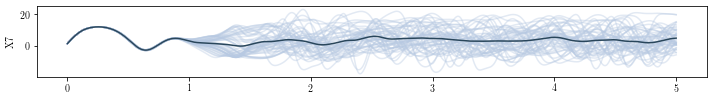

In [8]:
colors = ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue']
t_axis = np.arange(physical_ensemble.ensemble[0].num_timesteps+1)*physical_ensemble.ensemble[0].dt
for i in range(8):
    fig = plt.figure(figsize=(12,1.3))

    # Plot ensemble:
    for member in physical_ensemble.ensemble:
        plt.plot(t_axis, member.X[:,i], color=colors[1], alpha=0.4)
    
    # Plot mean:
    plt.plot(t_axis, physical_ensemble.mean[:,i], color=colors[2])
    
    plt.ylabel('X'+str(i))


## Comparing 1, 2 and 3 layer Lorenz-96 model

1000


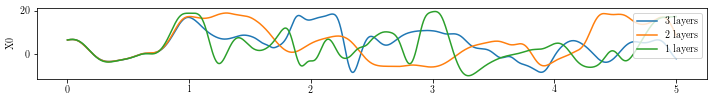

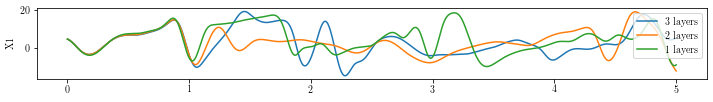

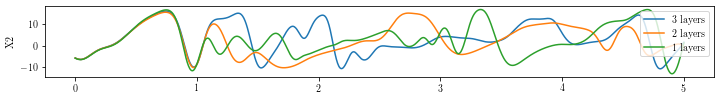

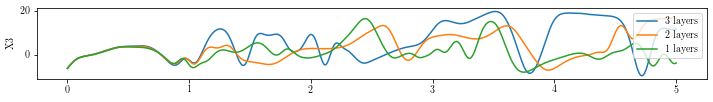

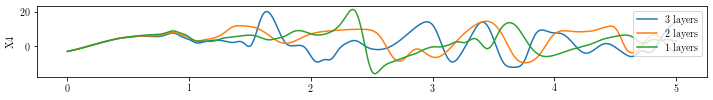

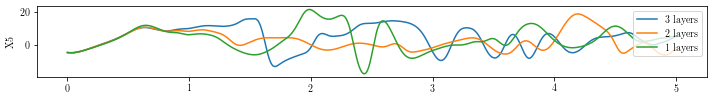

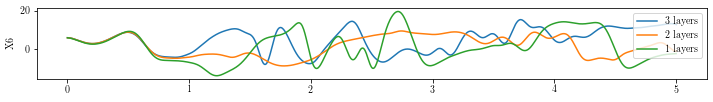

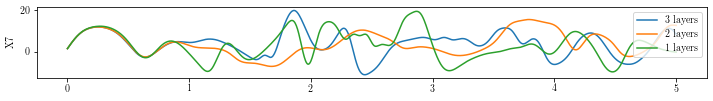

In [9]:
L96 = lorenz96(init_X=init_X, init_Y=init_Y, store_Y=True, store_Z=True)
L96_two_layer = lorenz96(init_X=init_X, init_Y=init_Y, num_layers=2)
L96_onelayer = lorenz96(init_X=init_X, num_layers=1)

L96.step(5)
L96_two_layer.step(5)
L96_onelayer.step(5)

for i in range(8):
    fig = plt.figure(figsize=(12,1.3))
    plt.plot(np.arange(L96.num_timesteps+1)*L96.dt, L96.X[:,i], label='3 layers')
    plt.plot(np.arange(L96.num_timesteps+1)*L96.dt, L96_two_layer.X[:,i], label='2 layers')
    plt.plot(np.arange(L96.num_timesteps+1)*L96.dt, L96_onelayer.X[:,i], label='1 layers')
    plt.legend(loc=1)
    plt.ylabel('X'+str(i))
print(L96.it)

### Example of values for Y and Z 

Text(0, 0.5, 'Y1')

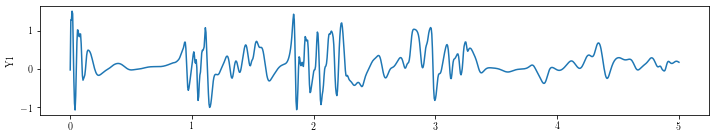

In [10]:
fig = plt.figure(figsize=(12,2))
plt.plot(np.arange(L96.num_timesteps+1)*L96.dt, L96.all_Y1[:,1])
plt.ylabel('Y1')

Text(0, 0.5, 'Z1')

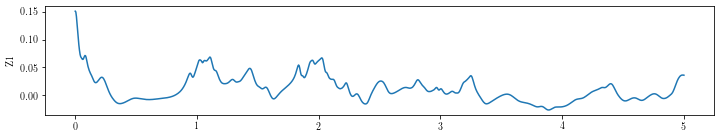

In [11]:
fig = plt.figure(figsize=(12,2))
plt.plot(np.arange(L96.num_timesteps+1)*L96.dt, L96.all_Z1[:,1])
plt.ylabel('Z1')

## Create a long time series of X that will be used for learning


In [48]:
#MTUs for training:
training_T = 10000

#### NB!!
# Setting training_T to a smaller value, so that the notebook won't take forever
# when you press run all.
# Please comment out this line if you want to make a sufficient training data set.
training_T = 10

long_L96 = lorenz96(init_X=init_X, init_Y=init_Y, end_T=training_T)


In [49]:
long_L96.step(training_T, verbose=True)

00 % after time (in s): 13.122340202331543
01 % after time (in s): 26.111877918243408
01 % after time (in s): 39.09378957748413
02 % after time (in s): 52.112793922424316
02 % after time (in s): 65.10224151611328
03 % after time (in s): 78.1590051651001
03 % after time (in s): 91.20028042793274
04 % after time (in s): 104.23468351364136
04 % after time (in s): 117.23816800117493
05 % after time (in s): 130.24565434455872
05 % after time (in s): 143.24370646476746
06 % after time (in s): 156.24915766716003
06 % after time (in s): 169.21441388130188
07 % after time (in s): 182.20701575279236
07 % after time (in s): 195.2260444164276
08 % after time (in s): 208.16163611412048
08 % after time (in s): 221.11905455589294
09 % after time (in s): 234.09939289093018
09 % after time (in s): 247.10397362709045
10 % after time (in s): 260.11501908302307
10 % after time (in s): 273.1152513027191
11 % after time (in s): 286.15253162384033
11 % after time (in s): 299.1221663951874
12 % after time (in

97 % after time (in s): 2517.025753259659
97 % after time (in s): 2529.994373321533
98 % after time (in s): 2542.9517860412598
98 % after time (in s): 2556.0053639411926
99 % after time (in s): 2569.024918079376
99 % after time (in s): 2582.02210187912


In [65]:
# Normalize values
normalized_X = long_L96.X.copy()
mean = normalized_X.mean()
stddev = normalized_X.std()
normalized_X = (normalized_X - mean)/stddev

(2000001, 8)


In [83]:
save_run = True
if save_run:
    folder_name = 'data/training_data_'+datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    os.makedirs(folder_name, exist_ok=True)
    
    np.savetxt(folder_name+'/actual_run.csv', long_L96.X, delimiter=',')
    np.savetxt(folder_name+'/normalized_run.csv', normalized_X, delimiter=',')
    
    np.savez(folder_name+'/mean_and_stddev.npz', mean=mean, stddev=stddev)
    np.savez(folder_name+'/actual_run.npz', X=long_L96.X)
    np.savez(folder_name+'/normalized_run.npz', X=normalized_X)
    
